In [1]:
!pip install pyspark boto3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 4.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
# Importa el módulo drive desde google.colab para interactuar con Google Drive.

drive.mount('/content/drive')
# Monta tu Google Drive en la ruta especificada ('/content/drive') para acceder a sus contenidos desde Google Colab.

Mounted at /content/drive


In [3]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
# Instala OpenJDK 11 en modo headless (sin entorno gráfico) en silencio (-qq) y redirige toda la salida a /dev/null.

!wget -q https://dlcdn.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz
# Descarga el archivo comprimido de Apache Spark 3.5.3 con soporte para Hadoop 3, silenciosamente (-q).

!tar xf spark-3.5.3-bin-hadoop3.tgz
# Extrae el contenido del archivo comprimido de Apache Spark.

!pip install -q findspark
# Instala el paquete findspark en silencio (-q), que facilita la integración de PySpark con Jupyter Notebooks.

In [4]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# Instala OpenJDK 8 en modo headless (sin entorno gráfico) en silencio (-qq) y redirige toda la salida a /dev/null.

!wget -q https://repo1.maven.org/maven2/org/apache/hadoop/hadoop-aws/3.2.0/hadoop-aws-3.2.0.jar
# Descarga en silencio (-q) el archivo JAR de hadoop-aws versión 3.2.0 del repositorio Maven.

!wget -q https://repo1.maven.org/maven2/com/amazonaws/aws-java-sdk-bundle/1.11.375/aws-java-sdk-bundle-1.11.375.jar
# Descarga en silencio (-q) el archivo JAR del AWS SDK para Java (paquete bundle) versión 1.11.375 del repositorio Maven.

In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"

In [6]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("data_processing")\
    .master("local[*]")\
    .config("spark.driver.memory","16G")\
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .config("spark.jars.packages", "com.amazonaws:aws-java-sdk:1.11.1034,org.apache.hadoop:hadoop-aws:3.3.4")\
    .config('fs.s3a.access.key', 'ACCESS KEY') \
    .config('fs.s3a.secret.key', 'SECRET KEY') \
    .config('fs.s3a.session.token', 'SESSION TOKEN') \
    .config('fs.s3a.path.style.access', 'true') \
    .config('fs.s3a.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem') \
    .config('fs.s3a.endpoint', 's3.amazonaws.com') \
    .getOrCreate()
sc = spark.sparkContext

In [7]:
spark
# Inicializa la variable spark con la sesión actual de Spark (si existe), en caso contrario,
# crea una nueva sesión de Spark.

spark = SparkSession.builder.appName("CovidAnalysis").getOrCreate()
# Construye una nueva sesión de Spark o recupera una existente, con el nombre de aplicación "CovidAnalysis".
# Almacena la sesión de Spark en la variable spark.


In [8]:
sc

<SparkContext master=local[*] appName=data_processing>

In [9]:
!wget -O Casos_positivos_de_COVID-19_en_Colombia.csv "https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv?accessType=DOWNLOAD"


--2024-11-24 01:05:15--  https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv?accessType=DOWNLOAD
Resolving www.datos.gov.co (www.datos.gov.co)... 52.206.68.26, 52.206.140.199, 52.206.140.205
Connecting to www.datos.gov.co (www.datos.gov.co)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘Casos_positivos_de_COVID-19_en_Colombia.csv’

Casos_positivos_de_     [                <=> ]   1.10G  6.66MB/s    in 2m 56s  

2024-11-24 01:08:11 (6.40 MB/s) - ‘Casos_positivos_de_COVID-19_en_Colombia.csv’ saved [1181518251]



In [10]:
from pyspark.sql import SparkSession
# Importa la clase SparkSession del módulo pyspark.sql, que se utiliza para crear una sesión de Spark.

df = spark.read.csv("Casos_positivos_de_COVID-19_en_Colombia.csv", header=True, inferSchema=True, encoding="UTF-8")
# Lee un archivo CSV llamado "Casos_positivos_de_COVID-19_en_Colombia.csv" en un DataFrame df.
# El parámetro header=True indica que la primera fila del archivo CSV contiene los nombres de las columnas.
# El parámetro inferSchema=True permite a Spark inferir automáticamente los tipos de datos de las columnas.
# El parámetro encoding="UTF-8" especifica que el archivo CSV está codificado en UTF-8.

In [11]:
df.columns
# Devuelve una lista con los nombres de todas las columnas en el DataFrame df.

['fecha reporte web',
 'ID de caso',
 'Fecha de notificación',
 'Código DIVIPOLA departamento',
 'Nombre departamento',
 'Código DIVIPOLA municipio',
 'Nombre municipio',
 'Edad',
 'Unidad de medida de edad',
 'Sexo',
 'Tipo de contagio',
 'Ubicación del caso',
 'Estado',
 'Código ISO del país',
 'Nombre del país',
 'Recuperado',
 'Fecha de inicio de síntomas',
 'Fecha de muerte',
 'Fecha de diagnóstico',
 'Fecha de recuperación',
 'Tipo de recuperación',
 'Pertenencia étnica',
 'Nombre del grupo étnico']

In [12]:
len(df.columns)
# Devuelve el número total de columnas en el DataFrame df.

23

In [13]:
df.count()
# Devuelve el número total de filas en el DataFrame df.

6390971

In [14]:
df.printSchema()
# Imprime el esquema del DataFrame df, mostrando el nombre de cada columna, su tipo de dato y si permite valores nulos.

root
 |-- fecha reporte web: timestamp (nullable = true)
 |-- ID de caso: integer (nullable = true)
 |-- Fecha de notificación: timestamp (nullable = true)
 |-- Código DIVIPOLA departamento: integer (nullable = true)
 |-- Nombre departamento: string (nullable = true)
 |-- Código DIVIPOLA municipio: integer (nullable = true)
 |-- Nombre municipio: string (nullable = true)
 |-- Edad: integer (nullable = true)
 |-- Unidad de medida de edad: integer (nullable = true)
 |-- Sexo: string (nullable = true)
 |-- Tipo de contagio: string (nullable = true)
 |-- Ubicación del caso: string (nullable = true)
 |-- Estado: string (nullable = true)
 |-- Código ISO del país: integer (nullable = true)
 |-- Nombre del país: string (nullable = true)
 |-- Recuperado: string (nullable = true)
 |-- Fecha de inicio de síntomas: timestamp (nullable = true)
 |-- Fecha de muerte: timestamp (nullable = true)
 |-- Fecha de diagnóstico: timestamp (nullable = true)
 |-- Fecha de recuperación: timestamp (nullable = tr

In [15]:
write_uri='s3a://jupyterbuck/bigdata/colab/csv/'

In [16]:
parquet_uri='s3a://jupyterbuck/bigdata/colab/parquet/'

In [17]:
selected_data = df.select("Nombre Departamento", "Nombre municipio", "Edad", "Sexo", "Fecha de diagnóstico")
# Selecciona las columnas "Nombre Departamento", "Nombre municipio", "Edad", "Sexo" y "Fecha de diagnóstico" del DataFrame df.
# Crea un nuevo DataFrame llamado selected_data con las columnas seleccionadas.

selected_data.show()
# Muestra las primeras 20 filas del DataFrame selected_data en un formato tabular.

selected_data.coalesce(1).write.format("csv").option("header", "true").mode("overwrite").save(write_uri + "selected_data.csv")
# Guarda el DataFrame selected_data en un archivo CSV en la ruta especificada en write_uri.

# Guardar los datos seleccionados en un archivo Parquet en S3 con sobrescritura
selected_data.write.format('parquet').mode("overwrite").save(parquet_uri + "selected_data_parquet")

+-------------------+----------------+----+----+--------------------+
|Nombre Departamento|Nombre municipio|Edad|Sexo|Fecha de diagnóstico|
+-------------------+----------------+----+----+--------------------+
|              VALLE|            CALI|  67|   F| 2020-12-23 00:00:00|
|              VALLE|            CALI|  66|   F| 2020-12-23 00:00:00|
|              VALLE|            CALI|  68|   F| 2020-12-22 00:00:00|
|              VALLE|            CALI|  74|   F| 2020-12-23 00:00:00|
|              VALLE|            CALI|  65|   F| 2020-12-23 00:00:00|
|              VALLE|            CALI|  66|   F| 2020-12-23 00:00:00|
|              VALLE|            CALI|  74|   F| 2020-12-22 00:00:00|
|              VALLE|            CALI|  66|   F| 2020-12-22 00:00:00|
|              VALLE|            CALI|  64|   F| 2020-12-23 00:00:00|
|              VALLE|            CALI|  65|   F| 2020-12-22 00:00:00|
|              VALLE|            CALI|  62|   F| 2020-12-23 00:00:00|
|              VALLE

In [18]:
df = df.withColumnRenamed("Nombre Municipio", "Municipio")
# Renombra la columna "Nombre Municipio" a "Municipio" en el DataFrame df.

df = df.withColumnRenamed("Nombre departamento", "Departamento")
# Renombra la columna "Nombre departamento" a "Departamento" en el DataFrame df.

In [19]:
from pyspark.sql.functions import udf
# Importa la función udf (User Defined Function) del módulo pyspark.sql.functions,
# que permite definir funciones personalizadas para columnas de DataFrame.

from pyspark.sql.types import StringType
# Importa el tipo de datos StringType del módulo pyspark.sql.types,
# que se utilizará para definir el tipo de retorno de la UDF.

def categorize_age(age):
    if age < 18:
        return "Menor"
    elif age < 60:
        return "Adulto"
    else:
        return "Mayor"
# Define una función Python llamada categorize_age que clasifica la edad de un individuo:
# Si la edad es menor de 18, retorna "Menor".
# Si la edad está entre 18 y 59 (inclusive), retorna "Adulto".
# Si la edad es 60 o mayor, retorna "Mayor".

age_udf = udf(categorize_age, StringType())
# Crea una UDF llamada age_udf a partir de la función categorize_age,
# especificando que el tipo de retorno es StringType.

data_with_age_group = df.withColumn("GrupoEdad", age_udf(df["Edad"]))
# Aplica la UDF age_udf a la columna "Edad" del DataFrame df,
# creando una nueva columna "GrupoEdad" con los valores categorizados.

# Muestra las primeras 20 filas del nuevo DataFrame data_with_age_group
data_with_age_group.show()

# Guardar los datos categorizados en un archivo CSV en S3 con sobrescritura
data_with_age_group.coalesce(1).write.format("csv").option("header", "true").mode("overwrite").save(write_uri + "categorized_data_csv")

# Guardar los datos categorizados en un archivo Parquet en S3 con sobrescritura
data_with_age_group.write.format('parquet').mode("overwrite").save(parquet_uri + "categorized_data_parquet")


+-------------------+----------+---------------------+----------------------------+---------------+-------------------------+-----------+----+------------------------+----+----------------+------------------+---------+-------------------+---------------+----------+---------------------------+-------------------+--------------------+---------------------+--------------------+------------------+-----------------------+---------+
|  fecha reporte web|ID de caso|Fecha de notificación|Código DIVIPOLA departamento|   Departamento|Código DIVIPOLA municipio|  Municipio|Edad|Unidad de medida de edad|Sexo|Tipo de contagio|Ubicación del caso|   Estado|Código ISO del país|Nombre del país|Recuperado|Fecha de inicio de síntomas|    Fecha de muerte|Fecha de diagnóstico|Fecha de recuperación|Tipo de recuperación|Pertenencia étnica|Nombre del grupo étnico|GrupoEdad|
+-------------------+----------+---------------------+----------------------------+---------------+-------------------------+-----------+-

In [21]:
results = df.groupBy("Departamento").count().orderBy("count", ascending=False)
# Agrupa el DataFrame df por la columna "Departamento".
# Cuenta el número de filas en cada grupo.
# Ordena los resultados por el número de filas (count) en orden descendente.
# Muestra las primeras 10 filas del DataFrame resultante en un formato tabular.
results.show()
results.coalesce(1).write.format("csv").option("header", "true").mode("overwrite").save(write_uri + "categorized_department")

# Guardar los datos categorizados en un archivo Parquet en S3 con sobrescritura
results.write.format('parquet').mode("overwrite").save(parquet_uri + "categorized_department")


+---------------+-------+
|   Departamento|  count|
+---------------+-------+
|         BOGOTA|1888137|
|      ANTIOQUIA| 955271|
|          VALLE| 572724|
|   CUNDINAMARCA| 331331|
|      SANTANDER| 297370|
|   BARRANQUILLA| 277989|
|      CARTAGENA| 163526|
|      ATLANTICO| 141072|
|         BOYACA| 131133|
|         TOLIMA| 127764|
|NORTE SANTANDER| 126015|
|        CORDOBA| 123095|
|         CALDAS| 120029|
|      RISARALDA| 110235|
|          CESAR| 109830|
|         NARIÑO| 108967|
|           META| 108194|
|          HUILA| 103578|
| STA MARTA D.E.|  84863|
|          CAUCA|  77337|
+---------------+-------+
only showing top 20 rows



In [22]:
result = df.groupBy("Municipio").count().orderBy("count", ascending=False)
# Agrupa el DataFrame df por la columna "Municipio".
# Cuenta el número de filas en cada grupo.
# Ordena los resultados por el número de filas (count) en orden descendente.
# Muestra las primeras 10 filas del DataFrame resultante en un formato tabular.
result.show()
result.coalesce(1).write.format("csv").option("header", "true").mode("overwrite").save(write_uri + "categorized_municipio")

# Guardar los datos categorizados en un archivo Parquet en S3 con sobrescritura
result.write.format('parquet').mode("overwrite").save(parquet_uri + "categorized_municipio")


+-------------+-------+
|    Municipio|  count|
+-------------+-------+
|       BOGOTA|1888137|
|     MEDELLIN| 550790|
|         CALI| 406751|
| BARRANQUILLA| 277989|
|    CARTAGENA| 163526|
|  BUCARAMANGA| 142842|
|       IBAGUE|  91598|
|  SANTA MARTA|  84863|
|    MANIZALES|  84478|
|       CUCUTA|  77359|
|   VALLEDUPAR|  76521|
|VILLAVICENCIO|  75855|
|      PEREIRA|  73507|
|        BELLO|  72629|
|      SOLEDAD|  67469|
|        NEIVA|  64465|
|     MONTERIA|  63595|
|       SOACHA|  63137|
|        PASTO|  61604|
|      ARMENIA|  55634|
+-------------+-------+
only showing top 20 rows



In [23]:
result = df.groupBy("Fecha de diagnóstico").count().orderBy("count", ascending=False)
# Agrupa el DataFrame df por la columna "Fecha de diagnóstico".
# Cuenta el número de filas en cada grupo.
# Ordena los resultados por el número de filas (count) en orden descendente.
# Muestra las primeras 10 filas del DataFrame resultante en un formato tabular.
result.show()
result.coalesce(1).write.format("csv").option("header", "true").mode("overwrite").save(write_uri + "categorized_fecha_diagnostico")

# Guardar los datos categorizados en un archivo Parquet en S3 con sobrescritura
result.write.format('parquet').mode("overwrite").save(parquet_uri + "categorized_fecha_diagnostico")


+--------------------+-----+
|Fecha de diagnóstico|count|
+--------------------+-----+
| 2022-01-07 00:00:00|42180|
| 2022-01-06 00:00:00|40352|
| 2022-01-12 00:00:00|35609|
| 2022-01-05 00:00:00|35551|
| 2022-01-11 00:00:00|35495|
| 2022-01-13 00:00:00|34791|
| 2021-06-25 00:00:00|34173|
| 2021-06-23 00:00:00|33936|
| 2021-06-15 00:00:00|33826|
| 2021-06-24 00:00:00|33220|
| 2021-06-21 00:00:00|33079|
| 2022-01-14 00:00:00|32906|
| 2021-06-16 00:00:00|32490|
| 2021-06-09 00:00:00|32454|
| 2022-01-08 00:00:00|32153|
| 2021-06-29 00:00:00|32103|
| 2021-06-11 00:00:00|31960|
| 2021-06-08 00:00:00|31859|
| 2021-06-17 00:00:00|31702|
| 2021-06-22 00:00:00|31469|
+--------------------+-----+
only showing top 20 rows



In [24]:
result = df.groupBy("Edad").count().orderBy("Edad")
# Agrupa el DataFrame df por la columna "Edad".
# Cuenta el número de filas en cada grupo.
# Ordena los resultados por la columna "Edad" en orden ascendente.
# Muestra todas las filas del DataFrame resultante en un formato tabular.
result.show()
result.coalesce(1).write.format("csv").option("header", "true").mode("overwrite").save(write_uri + "categorized_age")

# Guardar los datos categorizados en un archivo Parquet en S3 con sobrescritura
result.write.format('parquet').mode("overwrite").save(parquet_uri + "categorized_age")


+----+-----+
|Edad|count|
+----+-----+
|   1|33429|
|   2|26207|
|   3|24223|
|   4|23905|
|   5|24768|
|   6|26380|
|   7|26067|
|   8|28717|
|   9|30256|
|  10|31768|
|  11|34814|
|  12|34208|
|  13|36646|
|  14|39774|
|  15|43189|
|  16|46546|
|  17|52437|
|  18|64310|
|  19|80783|
|  20|93686|
+----+-----+
only showing top 20 rows



In [25]:
from pyspark.sql.functions import col
# Importa la función col del módulo pyspark.sql.functions, que se utiliza para acceder a las columnas de un DataFrame.

result = df.groupBy("Sexo").count().withColumn("Porcentaje", col("count") / df.count() * 100)
# Agrupa el DataFrame df por la columna "Sexo".
# Cuenta el número de filas en cada grupo.
# Crea una nueva columna "Porcentaje" que calcula el porcentaje de cada grupo en relación al total de filas del DataFrame df.
# Muestra todas las filas del DataFrame resultante en un formato tabular.
result.show()
result.coalesce(1).write.format("csv").option("header", "true").mode("overwrite").save(write_uri + "categorized_gender")

# Guardar los datos categorizados en un archivo Parquet en S3 con sobrescritura
result.write.format('parquet').mode("overwrite").save(parquet_uri + "categorized_gender")


+----+-------+--------------------+
|Sexo|  count|          Porcentaje|
+----+-------+--------------------+
|   F|3417087|  53.467415201852745|
|   f|      6|9.388244759677364E-5|
|   M|2973872|   46.53239703325207|
|   m|      6|9.388244759677364E-5|
+----+-------+--------------------+



In [26]:
df.createOrReplaceTempView("covid_data")
# Crea o reemplaza una vista temporal llamada "covid_data" a partir del DataFrame df.
# Esta vista temporal puede ser utilizada para ejecutar consultas SQL sobre el DataFrame df.

In [27]:
spark.sql("SELECT 'Nombre departamento', COUNT(*) as casos FROM covid_data GROUP BY 'Nombre departamento' ORDER BY casos DESC LIMIT 10").show()
# Ejecuta una consulta SQL sobre la vista temporal "covid_data".
# Selecciona la columna 'Nombre departamento' y cuenta el número de casos en cada grupo.
# Agrupa los resultados por la columna 'Nombre departamento'.
# Ordena los resultados por el número de casos (casos) en orden descendente.
# Limita los resultados a los 10 primeros registros.
# Muestra las primeras 20 filas del DataFrame resultante en un formato tabular.

+-------------------+-------+
|Nombre departamento|  casos|
+-------------------+-------+
|Nombre departamento|6390971|
+-------------------+-------+



In [28]:
import matplotlib.pyplot as plt


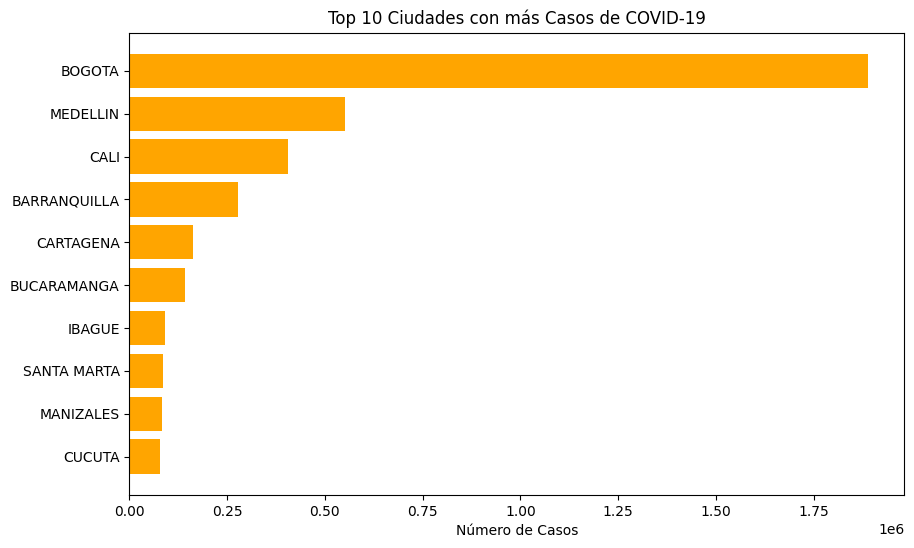

In [29]:
# Realizar el análisis en PySpark
top_cities = df.groupBy("Municipio").count() \
    .orderBy("count", ascending=False) \
    .limit(10).toPandas()
# Agrupa el DataFrame df por la columna "Municipio" y cuenta el número de filas en cada grupo.
# Ordena los resultados por el número de filas (count) en orden descendente.
# Limita los resultados a las 10 ciudades con más casos.
# Convierte el DataFrame resultante a un DataFrame de Pandas para su análisis y visualización.

# Crear el gráfico
plt.figure(figsize=(10, 6))
# Crea una nueva figura para el gráfico con un tamaño de 10x6 pulgadas.

plt.barh(top_cities["Municipio"], top_cities["count"], color="orange")
# Crea un gráfico de barras horizontales utilizando los datos de "Municipio" y "count" del DataFrame top_cities.
# El color de las barras es naranja.

plt.xlabel("Número de Casos")
# Añade una etiqueta al eje X del gráfico.

plt.title("Top 10 Ciudades con más Casos de COVID-19")
# Añade un título al gráfico.

plt.gca().invert_yaxis()
# Invierte el eje Y para que la ciudad con más casos aparezca en la parte superior.

plt.show()
# Muestra el gráfico.

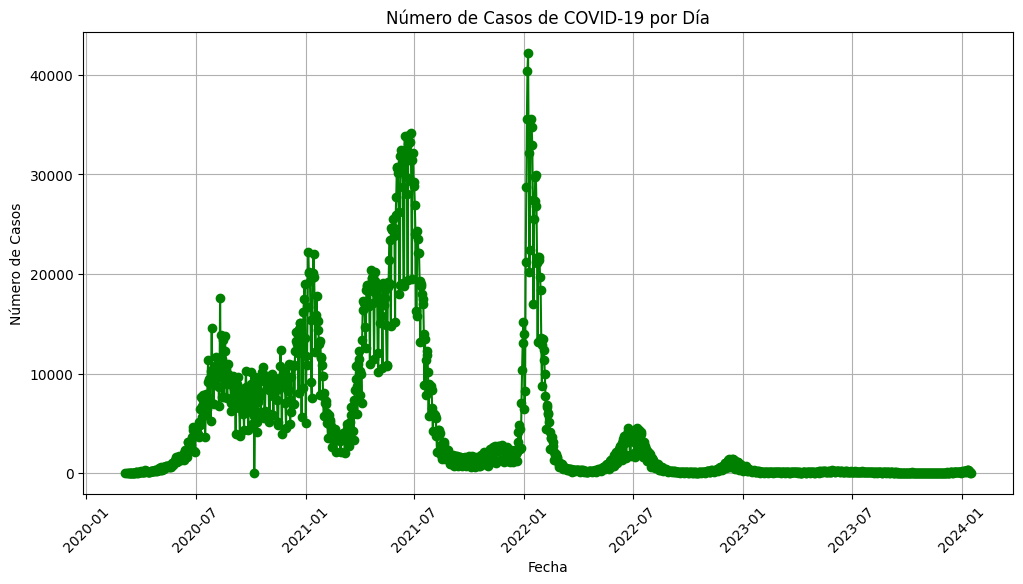

In [30]:
# Realizar el análisis en PySpark
cases_by_date = df.groupBy("Fecha de diagnóstico").count() \
    .orderBy("Fecha de diagnóstico").toPandas()
# Agrupa el DataFrame df por la columna "Fecha de diagnóstico" y cuenta el número de filas en cada grupo.
# Ordena los resultados por "Fecha de diagnóstico" en orden ascendente.
# Convierte el DataFrame resultante a un DataFrame de Pandas para su análisis y visualización.

# Crear el gráfico
plt.figure(figsize=(12, 6))
# Crea una nueva figura para el gráfico con un tamaño de 12x6 pulgadas.

plt.plot(cases_by_date["Fecha de diagnóstico"], cases_by_date["count"], marker="o", color="green")
# Crea un gráfico de líneas utilizando los datos de "Fecha de diagnóstico" y "count" del DataFrame cases_by_date.
# Marca cada punto de datos con un círculo (marker="o") y utiliza el color verde para la línea.

plt.xlabel("Fecha")
# Añade una etiqueta al eje X del gráfico.

plt.ylabel("Número de Casos")
# Añade una etiqueta al eje Y del gráfico.

plt.title("Número de Casos de COVID-19 por Día")
# Añade un título al gráfico.

plt.xticks(rotation=45)
# Rota las etiquetas del eje X 45 grados para mejorar la legibilidad.

plt.grid()
# Añade una cuadrícula al gráfico para facilitar la lectura de los valores.

plt.show()
# Muestra el gráfico.

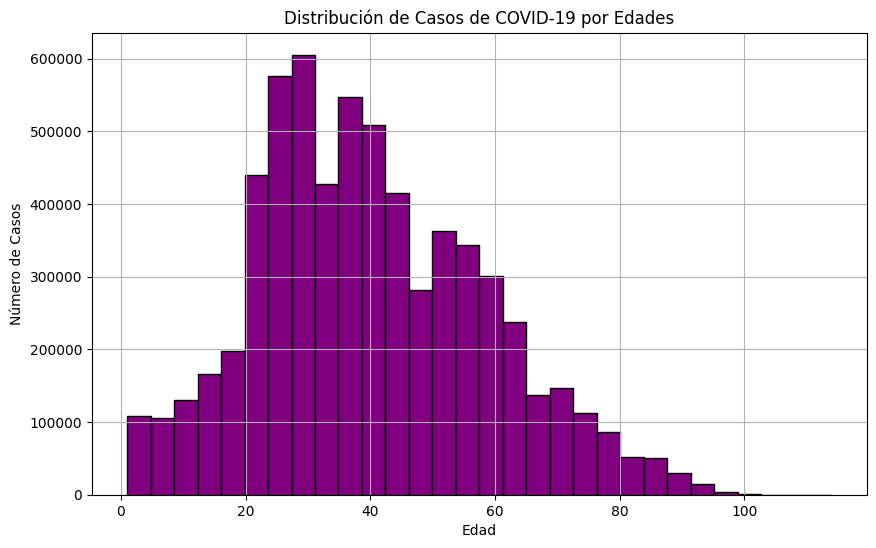

In [31]:
# Convertir a Pandas para graficar
age_distribution = df.select("Edad").toPandas()
# Selecciona la columna "Edad" del DataFrame df y la convierte en un DataFrame de Pandas para su análisis y visualización.

# Crear el histograma
plt.figure(figsize=(10, 6))
# Crea una nueva figura para el gráfico con un tamaño de 10x6 pulgadas.

plt.hist(age_distribution["Edad"], bins=30, color="purple", edgecolor="black")
# Crea un histograma utilizando los datos de "Edad" del DataFrame age_distribution.
# Usa 30 contenedores (bins) para agrupar las edades.
# Establece el color de las barras en púrpura y el color del borde de las barras en negro.

plt.xlabel("Edad")
# Añade una etiqueta al eje X del gráfico.

plt.ylabel("Número de Casos")
# Añade una etiqueta al eje Y del gráfico.

plt.title("Distribución de Casos de COVID-19 por Edades")
# Añade un título al gráfico.

plt.grid()
# Añade una cuadrícula al gráfico para facilitar la lectura de los valores.

plt.show()
# Muestra el gráfico.

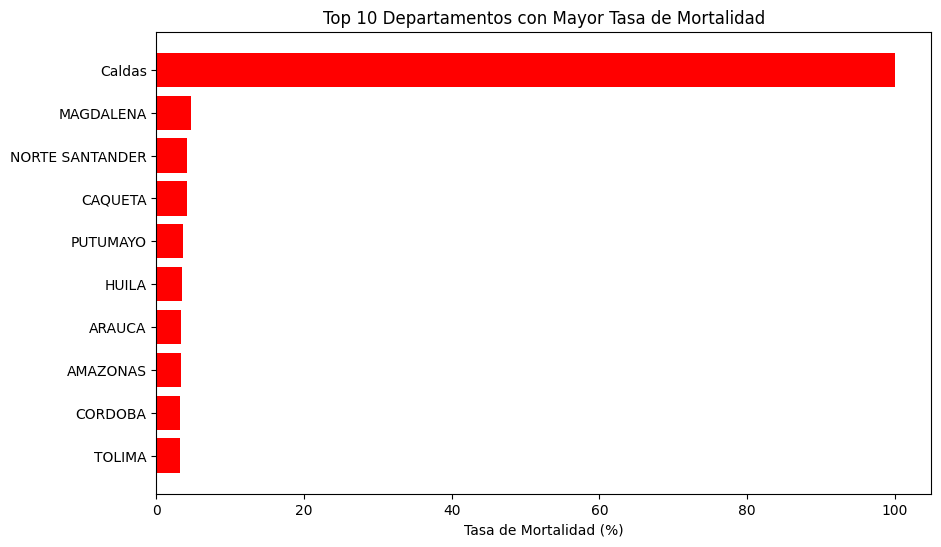

In [32]:
from pyspark.sql.functions import col, count, when
# Importa las funciones col, count y when del módulo pyspark.sql.functions,
# que se utilizarán para realizar agregaciones y condiciones en el DataFrame.

# Realizar el análisis en PySpark
mortality_rate = df.groupBy("Departamento").agg(
    (count(when(col("Estado") == "Fallecido", 1)) / count("*") * 100).alias("TasaMortalidad")
).orderBy("TasaMortalidad", ascending=False).limit(10).toPandas()
# Agrupa el DataFrame df por la columna "Departamento".
# Cuenta el número de casos donde la columna "Estado" es "Fallecido" y calcula el porcentaje de mortalidad.
# Ordena los resultados por la "TasaMortalidad" en orden descendente.
# Limita los resultados a los 10 departamentos con mayor tasa de mortalidad.
# Convierte el DataFrame resultante a un DataFrame de Pandas para su análisis y visualización.

# Crear el gráfico
plt.figure(figsize=(10, 6))
# Crea una nueva figura para el gráfico con un tamaño de 10x6 pulgadas.

plt.barh(mortality_rate["Departamento"], mortality_rate["TasaMortalidad"], color="red")
# Crea un gráfico de barras horizontales utilizando los datos de "Departamento" y "TasaMortalidad" del DataFrame mortality_rate.
# El color de las barras es rojo.

plt.xlabel("Tasa de Mortalidad (%)")
# Añade una etiqueta al eje X del gráfico.

plt.title("Top 10 Departamentos con Mayor Tasa de Mortalidad")
# Añade un título al gráfico.

plt.gca().invert_yaxis()
# Invierte el eje Y para que el departamento con mayor tasa de mortalidad aparezca en la parte superior.

plt.show()
# Muestra el gráfico.